In [1]:
# %matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def bypass(x):
    return x
def tanh(x):
    return np.tanh(x)
def softmax(x):
    exp = np.exp(x-x.max())
    return exp/exp.sum()
def d_softmax(data):
    sm = softmax(data)
    sm_vec = sm.reshape(-1, 1)
    return np.diag(sm)-sm_vec@sm_vec.T
def d_tanh(data):
    th = 1-tanh(data)**2
    return np.diag(th)
def d_bypass(x):
    return 1
differential = {softmax: d_softmax, tanh: d_tanh, bypass: d_bypass}

In [3]:
# 只需要修改这个框里面的东西即可
dimensions=[28*28, 100, 20, 10]
activation = [bypass, tanh, tanh, softmax]
distribution=[
    {}, # leave it empty
    {'b':[0, 0], 'w':[-math.sqrt(6/(dimensions[0]+ dimensions[1])), math.sqrt(6/(dimensions[0]+ dimensions[1]))]},
    {'b':[0, 0], 'w':[-math.sqrt(6/(dimensions[1]+ dimensions[2])), math.sqrt(6/(dimensions[1]+ dimensions[2]))]},
    {'b':[0, 0], 'w':[-math.sqrt(6/(dimensions[2]+ dimensions[3])), math.sqrt(6/(dimensions[2]+ dimensions[3]))]},
]

In [4]:
def init_parameters_b(layer):
    dist = distribution[layer]['b']
    return np.random.rand(dimensions[layer])*(dist[1]-dist[0]) + dist[0]
def init_parameters_w(layer):
    dist = distribution[layer]['w']
    return np.random.rand(dimensions[layer-1], dimensions[layer])*(dist[1]-dist[0]) + dist[0]
def init_parameters():
    parameter = []
    for i in range(len(distribution)):
        layer_parameter={}
        for j in distribution[i].keys():
            if j=='b':
                layer_parameter['b']=init_parameters_b(i)
                continue
            if j=='w':
                layer_parameter['w']=init_parameters_w(i)
                continue
        parameter.append(layer_parameter)
    return parameter

In [5]:
def predict(img, parameters):
    l_in=img
    l_out = activation[0](l_in)
    for layer in range(1, len(dimensions)):
        l_in = np.dot(l_out, parameters[layer]['w']) + parameters[layer]['b']
        l_out = activation[layer](l_in)
    return l_out

In [6]:
mnist_x_train = np.load('mnist_x_train.npy')
tmp_y = np.load('mnist_y_train.npy')
mnist_x_test = np.load('mnist_x_test.npy')
mnist_y_test = np.load('mnist_y_test.npy')
m1, m2, m3 = mnist_x_train.shape
tmp = mnist_x_train.reshape(-1, m2*m3)
mnist_x_test = mnist_x_test.reshape(-1, m2*m3)

train_num = 50000
valid_num = 10000
test_num = 10000

mnist_x_train = tmp[:train_num]
mnist_x_valid = tmp[train_num:]
mnist_y_train = tmp_y[:train_num]
mnist_y_valid = tmp_y[train_num:]

mnist_x_train = np.divide(mnist_x_train, 255)
mnist_x_valid = np.divide(mnist_x_valid, 255)
mnist_x_test = np.divide(mnist_x_test, 255)
print(mnist_x_train.shape)
print(mnist_x_valid.shape)
print(mnist_x_test.shape)
print(mnist_y_train.shape)
print(mnist_y_valid.shape)
print(mnist_y_test.shape)

(50000, 784)
(10000, 784)
(10000, 784)
(50000,)
(10000,)
(10000,)


In [7]:
def show_train(index):
    plt.imshow(mnist_x_train[index].reshape(28, 28), cmap='gray')
    print(f'label: {mnist_y_train[index]}')
def show_valid(index):
    plt.imshow(mnist_x_valid[index].reshape(28, 28), cmap='gray')
    print(f'label: {mnist_y_valid[index]}')
def show_test(index):
    plt.imshow(mnist_x_test[index].reshape(28, 28), cmap='gray')
    print(f'label: {mnist_y_test[index]}')

label: 7


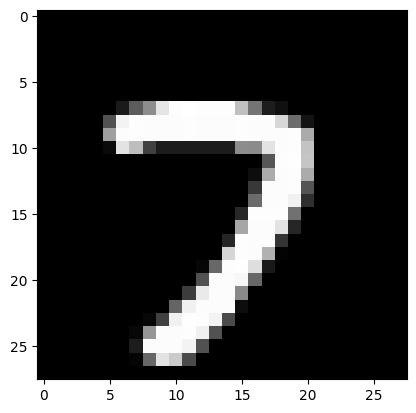

In [8]:
show_train(np.random.randint(train_num-1))

label: 4


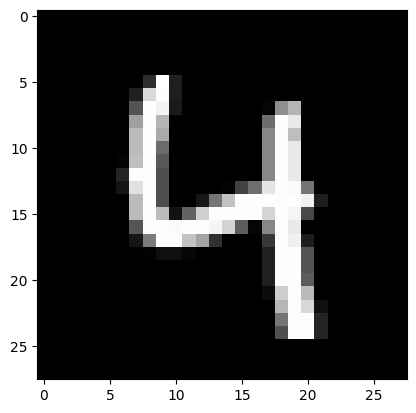

In [9]:
show_valid(np.random.randint(valid_num-1))

label: 7


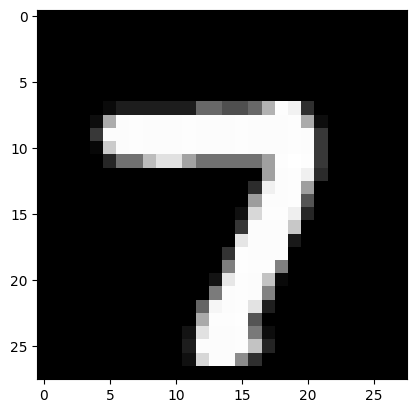

In [10]:
show_test(np.random.randint(test_num-1))

In [11]:
# 用来验证 softmax和tanh函数的导数求解是否正确
h = 0.0001
func = softmax
input_len = 4

test_input = np.random.rand(input_len)
true_derivation = differential[func](test_input)
esti_derivation = np.zeros((input_len, input_len))
for i in range(input_len):
    for j in range(input_len):
        value1 = func(test_input)[i]
        new_input = test_input.copy()
        new_input[j] += h
        value2 = func(new_input)[i]
        esti_derivation[i][j] = (value2 - value1)/h
print(esti_derivation-true_derivation)

[[ 4.81056057e-06 -1.17071017e-06 -1.25882897e-06 -1.33693578e-06]
 [-2.07205000e-06  3.61633615e-06 -1.98972533e-06 -2.11318246e-06]
 [-1.15712727e-06 -1.03337228e-06  4.76710790e-06 -1.18009740e-06]
 [-1.58138274e-06 -1.41225315e-06 -1.51855305e-06  4.63021564e-06]]


In [12]:
onehot = np.identity(dimensions[-1])
def sqr_loss(img, label, parameters):
    y_pred = predict(img, parameters)
    y = onehot[label]
    diff = y - y_pred
    return np.dot(diff, diff)

In [13]:
def grad_parameters(img, label, parameters):
    l_in_list = [img]
    l_out_list = [activation[0](l_in_list[0])]
    for layer in range(1, len(dimensions)):
        l_in = np.dot(l_out_list[layer-1], parameters[layer]['w']) + parameters[layer]['b']
        l_out = activation[layer](l_in)
        l_in_list.append(l_in)
        l_out_list.append(l_out)
    
    d_layer = 2 * (l_out_list[-1] - onehot[label])
    grad_result = [None]*len(dimensions)
    for layer in range(len(dimensions)-1, 0, -1):
        d_layer = d_layer @ differential[activation[layer]](l_in_list[layer])
        grad_result[layer] = {}
        grad_result[layer]['b'] = d_layer
        tmp = d_layer.reshape(1, -1)
        tmp_2 = l_out_list[layer-1].reshape(-1, 1)
        grad_result[layer]['w'] = tmp_2 @ tmp
        d_layer = d_layer @ parameters[layer]['w'].T
    return grad_result

In [14]:
# grad_parameters(mnist_x_train[0], mnist_y_train[0], init_parameters())

In [15]:
# 用来验证对 b1 的导数求解是否正确
h = 0.00001
layer = 1

pname='b'
img_i = np.random.randint(train_num)
test_parameters = init_parameters()
true_derivative = grad_parameters(mnist_x_train[img_i], mnist_y_train[img_i], test_parameters)[layer][pname]
esti_derivative = np.zeros(dimensions[layer])
for i in range(dimensions[layer]):
    value1 = sqr_loss(mnist_x_train[img_i], mnist_y_train[img_i], test_parameters)
    tmp = test_parameters.copy()
    tmp[layer][pname][i] += h
    value2 = sqr_loss(mnist_x_train[img_i], mnist_y_train[img_i], tmp)
    esti_derivative[i] = (value2 - value1)/h
print(abs(esti_derivative - true_derivative).max())
# print(esti_derivative - true_derivative)

1.05299378457685e-06


In [19]:
# 用来验证对 w1 的导数求解是否正确
h = 0.000001
layer = 1

pname='w'
img_i = np.random.randint(train_num)
test_parameters = init_parameters()
true_derivative = grad_parameters(mnist_x_train[img_i], mnist_y_train[img_i], test_parameters)[layer][pname]
esti_derivative = np.zeros((dimensions[layer-1], dimensions[layer]))
for i in tqdm(range(dimensions[layer-1])):
    for j in range(dimensions[layer]):
        value1 = sqr_loss(mnist_x_train[img_i], mnist_y_train[img_i], test_parameters)
        tmp = test_parameters.copy()
        tmp[layer][pname][i][j] += h
        value2 = sqr_loss(mnist_x_train[img_i], mnist_y_train[img_i], tmp)
        esti_derivative[i][j] = (value2 - value1)/h
print(abs(esti_derivative - true_derivative).max())
# print(esti_derivative - true_derivative)

  0%|          | 0/784 [00:00<?, ?it/s]

3.405505658117536e-06


In [20]:
def valid_loss(parameters):
    loss_accu = 0
    for img_i in range(valid_num):
        loss_accu += sqr_loss(mnist_x_valid[img_i], mnist_y_valid[img_i], parameters)
    return loss_accu/(valid_num/1000)
def train_loss(parameters):
    loss_accu = 0
    for img_i in range(train_num):
        loss_accu += sqr_loss(mnist_x_train[img_i], mnist_y_train[img_i], parameters)
    return loss_accu/(train_num/1000)
def valid_accuracy(parameters):
    correct = []
    for img_i in range(valid_num):
        t = predict(mnist_x_valid[img_i], parameters).argmax() == mnist_y_valid[img_i]
        correct.append(t)
    return correct.count(True)/len(correct)
def train_accuracy(parameters):
    correct = []
    for img_i in range(train_num):
        t = predict(mnist_x_train[img_i], parameters).argmax() == mnist_y_train[img_i]
        correct.append(t)
    return correct.count(True)/len(correct)
def test_accuracy(parameters):
    correct = []
    for img_i in range(test_num):
        t = predict(mnist_x_test[img_i], parameters).argmax() == mnist_y_test[img_i]
        correct.append(t)
    return correct.count(True)/len(correct)

In [21]:
batch_size=100

In [22]:
def grad_add(grad1, grad2):
    for layer in range(1, len(grad1)):
        for pname in grad1[layer].keys():
            grad1[layer][pname] += grad2[layer][pname]
    return grad1

def grad_divide(grad, denominator):
    for layer in range(1, len(grad)):
        for pname in grad[layer].keys():
            grad[layer][pname] /= denominator
    return grad

def batch_grad_avg(current_batch, parameters):
    grad_accu = grad_parameters(mnist_x_train[current_batch*batch_size+0], mnist_y_train[current_batch*batch_size+0], parameters)
    for img_i in range(1, batch_size):
        grad_tmp = grad_parameters(mnist_x_train[current_batch*batch_size+img_i], mnist_y_train[current_batch*batch_size+img_i], parameters)
        grad_add(grad_accu, grad_tmp)
    grad_divide(grad_accu, batch_size)
    return grad_accu

In [23]:
def step(parameters, grad, learning_rate):
    parameters_tmp = parameters.copy()
    for layer in range(1, len(parameters_tmp)):
        for pname in parameters_tmp[layer].keys():
            parameters_tmp[layer][pname] -= learning_rate*grad[layer][pname]
    return parameters_tmp

In [24]:
# 下面开始训练
parameters = init_parameters()
train_loss_array = []
train_loss_array.append(train_loss(parameters))
valid_loss_array = []
valid_loss_array.append(valid_loss(parameters))
train_accu = []
train_accu.append(train_accuracy(parameters))
valid_accu = []
valid_accu.append(valid_accuracy(parameters))

In [25]:
valid_accuracy(parameters)

0.0881

In [37]:
batch_num = train_num // batch_size
learn_rate = 0.3
for epoch in tqdm(range(5)):
    print(f"epoch: {epoch}")
    for i in range(batch_num):
        grad_tmp = batch_grad_avg(i, parameters)
        parameters = step(parameters, grad_tmp, learn_rate)
    train_loss_array.append(train_loss(parameters))
    valid_loss_array.append(valid_loss(parameters))
    train_accu.append(train_accuracy(parameters))
    valid_accu.append(valid_accuracy(parameters))

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4


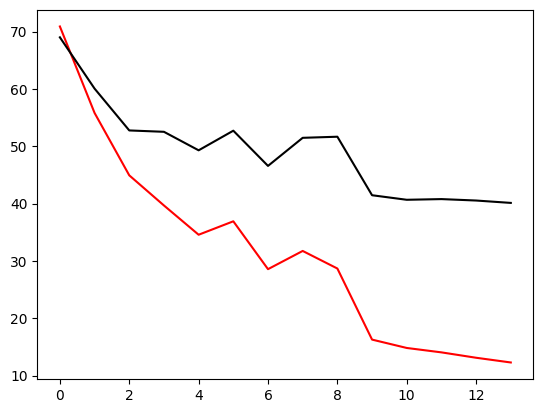

In [38]:
lower = 2
plt.plot(train_loss_array[lower:], color='red', label='train loss')
plt.plot(valid_loss_array[lower:], color='black', label='valid loss')
plt.show()

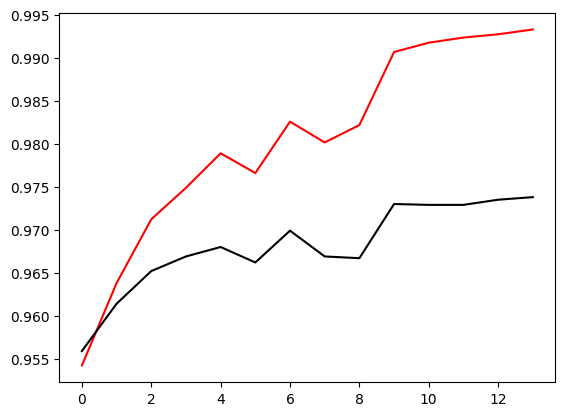

In [39]:
plt.plot(train_accu[lower:], color='red', label='train accuracy')
plt.plot(valid_accu[lower:], color='black', label='valid accuracy')
plt.show()

In [40]:
print(train_accuracy(parameters))
print(valid_accuracy(parameters))

0.9933
0.9738


In [41]:
print(test_accuracy(parameters))

0.9743
